In [1]:
# CNN AND LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv(r"C:\Users\ADWIN ADI\Downloads\MainData_30sec_Segmented.csv")
df['Label'] = df['Label'].str.strip()

# Encode labels
label_encoder = LabelEncoder()
df['Label_encoded'] = label_encoder.fit_transform(df['Label'])

# Define features
features = ['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity',
            'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity']
segments = df['segment_id'].nunique()
time_steps = df[df['segment_id'] == 0].shape[0]

# Reshape input and output
X = df[features].values.reshape(segments, time_steps, len(features))
y = df['Label_encoded'].values[::time_steps]

# One-hot encode targets
onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Build CNN + LSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(time_steps, len(features))),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(100),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Metrics
f1 = f1_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

# Function to compute the categorical cross-entropy loss for each class
def compute_class_loss(y_true, y_pred, num_classes):
    class_losses = []
    y_true_onehot = K.one_hot(y_true, num_classes)
    
    for i in range(num_classes):
        # Create a mask for the current class
        class_mask = K.cast(K.equal(y_true, i), K.floatx())
        # Compute the categorical cross-entropy loss for the current class
        loss_class = K.categorical_crossentropy(y_true_onehot, y_pred)
        # Compute the average loss for the current class
        class_losses.append(K.mean(loss_class * class_mask))
    
    return K.eval(K.stack(class_losses))

# Compute the class-wise losses
class_losses = compute_class_loss(y_true, y_pred_probs, len(label_encoder.classes_))

# Function to compute specificity
def compute_specificity(cm):
    specificity_scores = []
    for i in range(len(cm)):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_scores.append(specificity)
    return specificity_scores

specificity = compute_specificity(conf_matrix)

# Class-wise Accuracy
class_accuracies = []
for i in range(len(conf_matrix)):
    correct = conf_matrix[i, i]
    total = conf_matrix[i, :].sum()
    class_accuracy = correct / total if total > 0 else 0
    class_accuracies.append(class_accuracy)

# Create performance table
labels = label_encoder.classes_
performance_df = pd.DataFrame({
    'Class': labels,
    'F1 Score': np.round(f1, 4),
    'Recall': np.round(recall, 4),
    'Specificity': np.round(specificity, 4),
    'Class Accuracy': np.round(class_accuracies, 4),
    'Class Loss': np.round(class_losses, 4)  # Add class loss column
})

# Display performance table
print("\n  Class-wise Performance Table with Class Loss:\n")
print(performance_df.to_string(index=False))

# Display overall accuracy and loss separately
print("\n Overall Evaluation:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - Loss:     {loss:.4f}")

# Create and show loss table
loss_table = pd.DataFrame({
    'Metric': ['Overall Accuracy', 'Overall Loss'],
    'Value': [round(accuracy, 4), round(loss, 4)]
})

print("\n Overall Loss Table:\n")
print(loss_table.to_string(index=False))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 145, 64)           2368      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 72, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 72, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

ValueError: in user code:

    File "C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 3) and (None, 6) are incompatible


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize




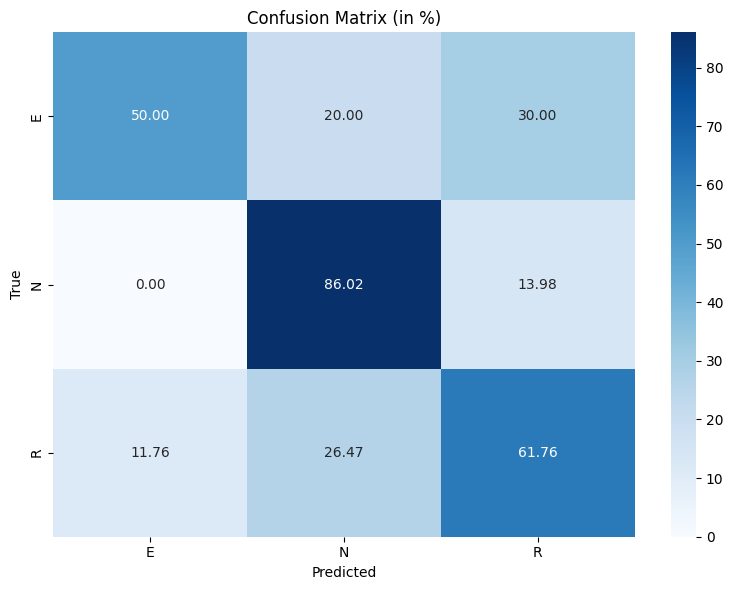

In [12]:
# Convert to percentage
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix as heatmap (percentage)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (in %)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


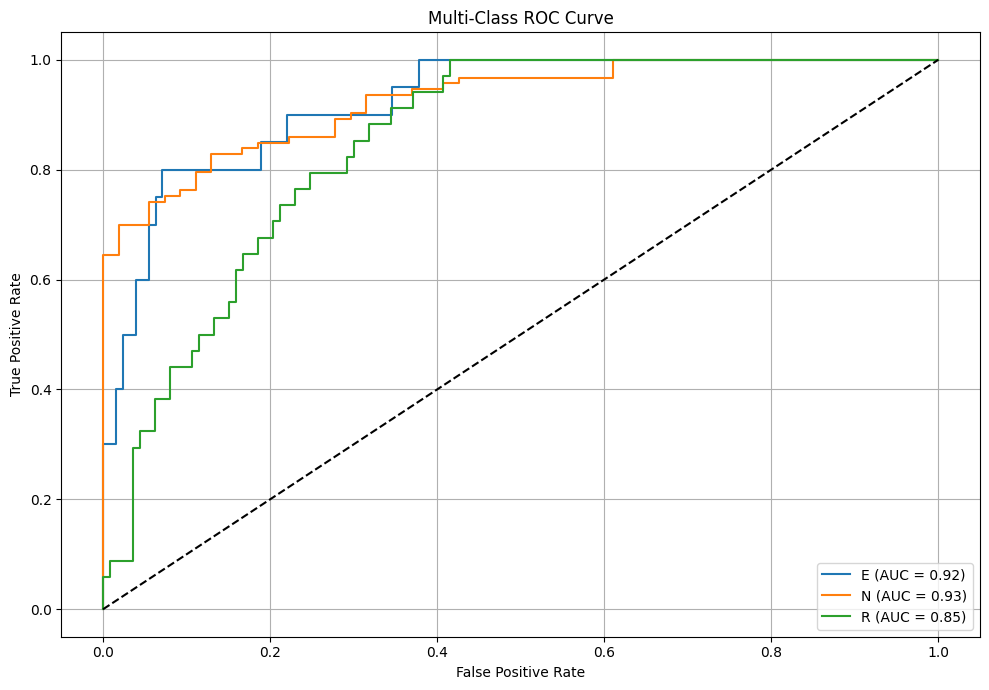

In [13]:
# Binarize true and predicted labels for ROC
y_test_binarized = label_binarize(y_true, classes=range(len(labels)))
n_classes = y_test_binarized.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("Multi-Class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
#LSTM AND TRANSFORMER
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Dropout, LayerNormalization, MultiHeadAttention, Conv1D, MaxPooling1D, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess data
df = pd.read_csv(r"C:\Users\ADWIN ADI\Downloads\MainData_30sec_Segmented.csv")
df['Label'] = df['Label'].str.strip()

# Label encoding
label_encoder = LabelEncoder()
df['Label_encoded'] = label_encoder.fit_transform(df['Label'])

# Segment and reshape data
features = ['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity',
            'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity']
segments = df['segment_id'].nunique()
time_steps = df[df['segment_id'] == 0].shape[0]
X = df[features].values.reshape(segments, time_steps, len(features))
y = df['Label_encoded'].values[::time_steps]

# One-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ------------------ MODEL OPTIONS ------------------ #

def build_lstm_model():
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(time_steps, len(features))),
        Dropout(0.3),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(y_encoded.shape[1], activation='softmax')
    ])
    return model

def build_transformer_encoder_model():
    input_layer = Input(shape=(time_steps, len(features)))
    x = LayerNormalization(epsilon=1e-6)(input_layer)
    x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = Dropout(0.3)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(128, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    output = Dense(y_encoded.shape[1], activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output)
    return model

# Choose model here: lstm_model or transformer_model
model = build_lstm_model()  # ← Change to build_transformer_encoder_model() for Transformer

# ------------------ TRAINING ------------------ #

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

# ------------------ EVALUATION ------------------ #

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)

f1 = f1_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

def compute_class_loss(y_true, y_pred, num_classes):
    class_losses = []
    y_true_onehot = K.one_hot(y_true, num_classes)
    for i in range(num_classes):
        class_mask = K.cast(K.equal(y_true, i), K.floatx())
        loss_class = K.categorical_crossentropy(y_true_onehot, y_pred)
        class_losses.append(K.mean(loss_class * class_mask))
    return K.eval(K.stack(class_losses))

class_losses = compute_class_loss(y_true, y_pred_probs, y_encoded.shape[1])

def compute_specificity(cm):
    specificity_scores = []
    for i in range(len(cm)):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_scores.append(specificity)
    return specificity_scores

specificity = compute_specificity(conf_matrix)
class_accuracies = [conf_matrix[i, i] / conf_matrix[i, :].sum() if conf_matrix[i, :].sum() > 0 else 0 for i in range(len(conf_matrix))]

labels = label_encoder.classes_
performance_df = pd.DataFrame({
    'Class': labels,
    'F1 Score': np.round(f1, 4),
    'Recall': np.round(recall, 4),
    'Specificity': np.round(specificity, 4),
    'Class Accuracy': np.round(class_accuracies, 4),
    'Class Loss': np.round(class_losses, 4)
})

print("\n  Class-wise Performance Table with Class Loss:\n")
print(performance_df.to_string(index=False))

print("\n Overall Evaluation:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - Loss:     {loss:.4f}")

loss_table = pd.DataFrame({
    'Metric': ['Overall Accuracy', 'Overall Loss'],
    'Value': [round(accuracy, 4), round(loss, 4)]
})

print("\n Overall Loss Table:\n")
print(loss_table.to_string(index=False))


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 150, 128)          69120     
                                                                 
 dropout_17 (Dropout)        (None, 150, 128)          0         
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 3)                 195       
                                                                 
Total params: 122,883
Trainable params: 122,883
Non-tr

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


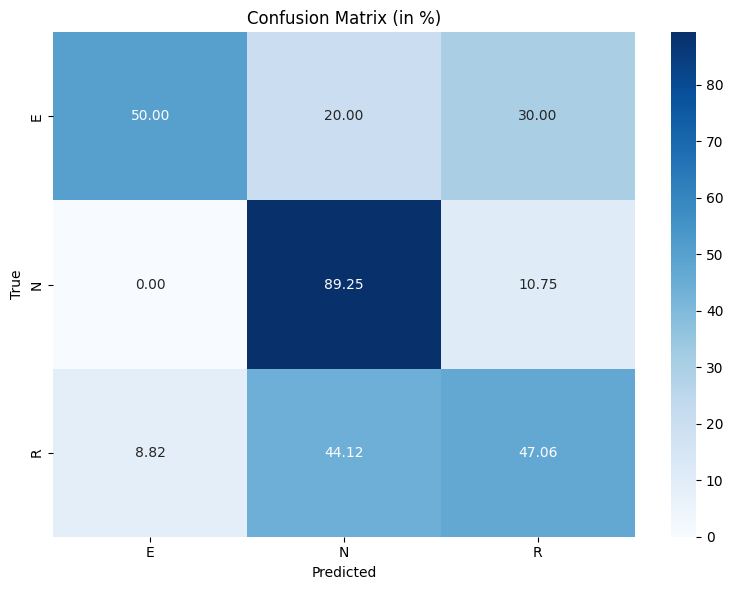

In [16]:
# Convert to percentage
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix as heatmap (percentage)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (in %)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


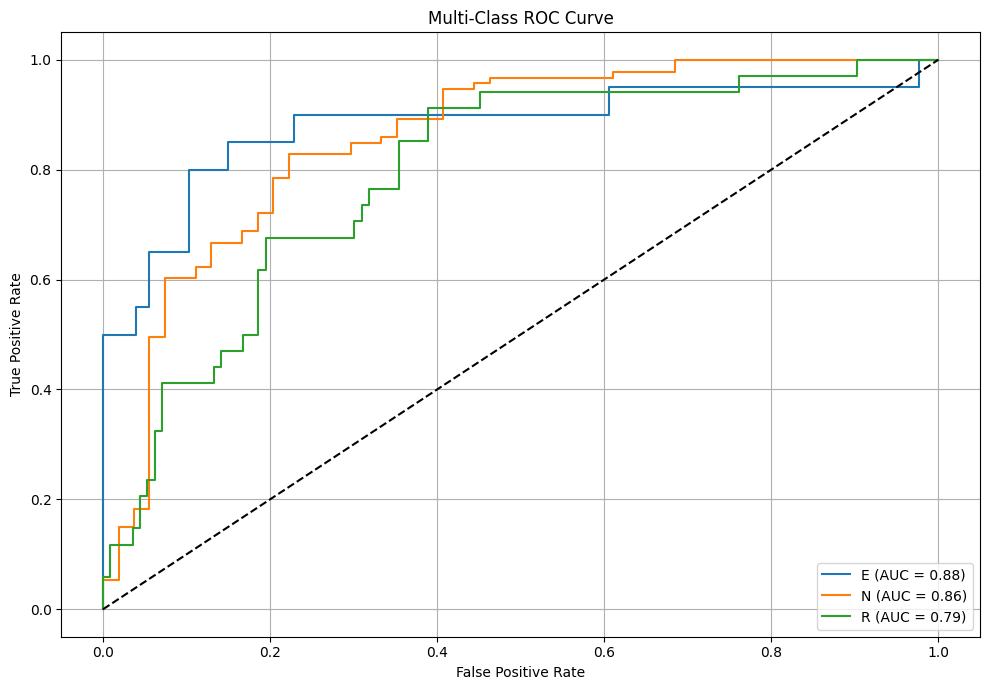

In [17]:
# Binarize true and predicted labels for ROC
y_test_binarized = label_binarize(y_true, classes=range(len(labels)))
n_classes = y_test_binarized.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("Multi-Class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, Dense,
    MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Add
)
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv(r"C:\Users\ADWIN ADI\Downloads\MainData_30sec_Segmented.csv")
df['Label'] = df['Label'].str.strip()

# Encode labels
label_encoder = LabelEncoder()
df['Label_encoded'] = label_encoder.fit_transform(df['Label'])

# Define features
features = ['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity',
            'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity']
segments = df['segment_id'].nunique()
time_steps = df[df['segment_id'] == 0].shape[0]

# Reshape input and output
X = df[features].values.reshape(segments, time_steps, len(features))
y = df['Label_encoded'].values[::time_steps]

# One-hot encode targets
onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- MODEL: CNN + TRANSFORMER ENCODER ---
input_layer = Input(shape=(time_steps, len(features)))

# CNN Block
x = Conv1D(filters=64, kernel_size=6, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Transformer Encoder Block
attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
attn_output = Dropout(0.3)(attn_output)
x1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

# Feed-forward block
ff = Dense(64, activation='relu')(x1)
ff = Dropout(0.3)(ff)
ff_output = Dense(64)(ff)
x2 = LayerNormalization(epsilon=1e-6)(x1 + ff_output)

# Global pooling + Classification
x = GlobalAveragePooling1D()(x2)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

# Evaluation
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# F1 and Recall
f1 = f1_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

# Categorical cross-entropy loss per class
def compute_class_loss(y_true, y_pred, num_classes):
    class_losses = []
    y_true_onehot = K.one_hot(y_true, num_classes)
    for i in range(num_classes):
        class_mask = K.cast(K.equal(y_true, i), K.floatx())
        loss_class = K.categorical_crossentropy(y_true_onehot, y_pred)
        class_losses.append(K.mean(loss_class * class_mask))
    return K.eval(K.stack(class_losses))

class_losses = compute_class_loss(y_true, y_pred_probs, len(label_encoder.classes_))

# Specificity
def compute_specificity(cm):
    specificity_scores = []
    for i in range(len(cm)):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_scores.append(specificity)
    return specificity_scores

specificity = compute_specificity(conf_matrix)

# Class Accuracy
class_accuracies = []
for i in range(len(conf_matrix)):
    correct = conf_matrix[i, i]
    total = conf_matrix[i, :].sum()
    class_accuracy = correct / total if total > 0 else 0
    class_accuracies.append(class_accuracy)

# Final Performance Table
labels = label_encoder.classes_
performance_df = pd.DataFrame({
    'Class': labels,
    'F1 Score': np.round(f1, 4),
    'Recall': np.round(recall, 4),
    'Specificity': np.round(specificity, 4),
    'Class Accuracy': np.round(class_accuracies, 4),
    'Class Loss': np.round(class_losses, 4)
})

print("\n  Class-wise Performance Table with Class Loss:\n")
print(performance_df.to_string(index=False))

print("\n Overall Evaluation:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - Loss:     {loss:.4f}")

loss_table = pd.DataFrame({
    'Metric': ['Overall Accuracy', 'Overall Loss'],
    'Value': [round(accuracy, 4), round(loss, 4)]
})

print("\n Overall Loss Table:\n")
print(loss_table.to_string(index=False))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 6)]     0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 145, 64)      2368        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d_9 (MaxPooling1D)  (None, 72, 64)      0           ['conv1d_9[0][0]']               
                                                                                                  
 dropout_19 (Dropout)           (None, 72, 64)       0           ['max_pooling1d_9[0][0]']        
                                                                                              

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


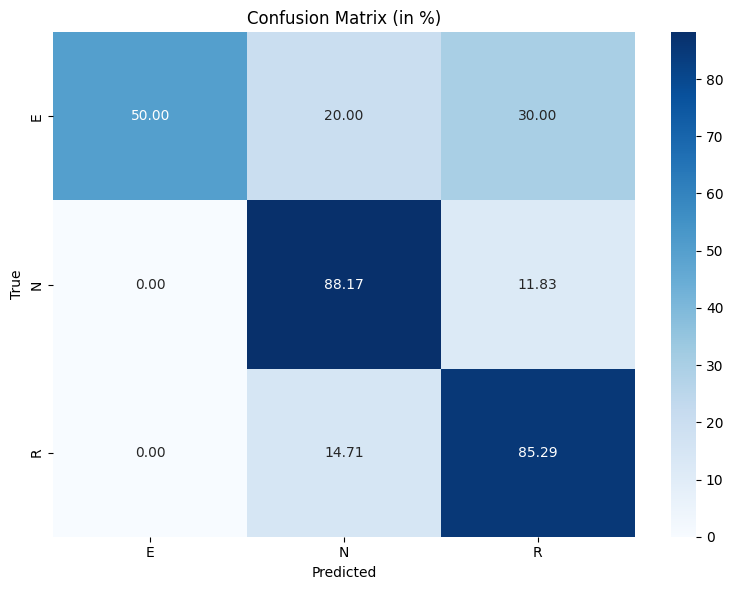

In [20]:
# Convert to percentage
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix as heatmap (percentage)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (in %)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

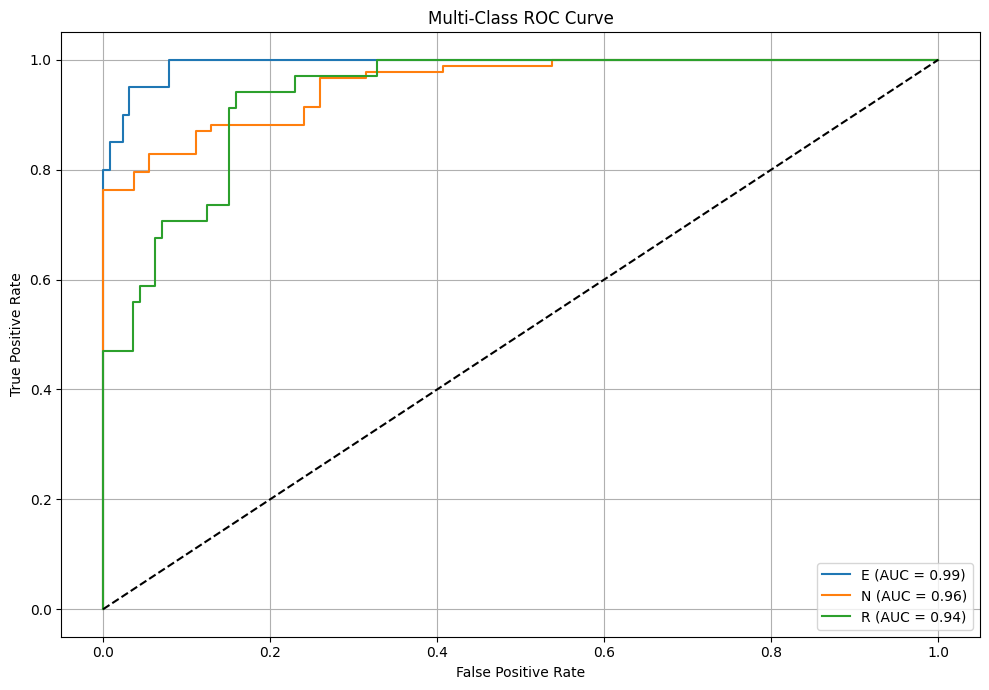

In [21]:
# Binarize true and predicted labels for ROC
y_test_binarized = label_binarize(y_true, classes=range(len(labels)))
n_classes = y_test_binarized.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("Multi-Class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 6)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 150, 64)      1216        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 75, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 lstm (LSTM)                    (None, 75, 64)       33024       ['max_pooling1d[0][0]']          
                                                                                              

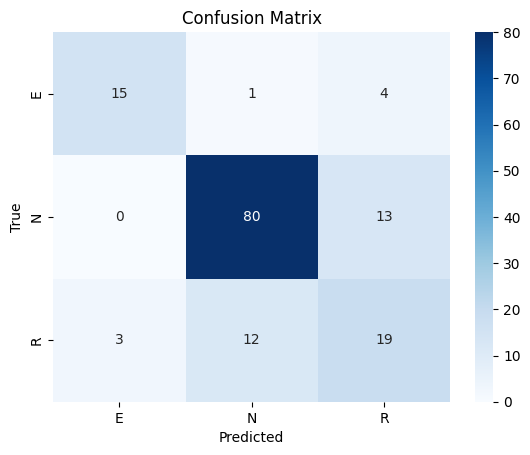


Final Performance Table:
  Class  F1 Score    Recall  Specificity  Accuracy  Cross-Entropy Loss
0     E  0.789474  0.750000     0.976378  0.750000            1.442987
1     N  0.860215  0.860215     0.759259  0.860215            0.730369
2     R  0.542857  0.558824     0.849558  0.558824            2.079189


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Layer, GlobalAveragePooling1D, Add, Softmax
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load & Preprocess Data
# -----------------------------
df = pd.read_csv(r"C:\Users\ADWIN ADI\Downloads\MainData_30sec_Segmented.csv")
df['Label'] = df['Label'].str.strip()
label_encoder = LabelEncoder()
df['Label_encoded'] = label_encoder.fit_transform(df['Label'])

features = ['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity',
            'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity']
segments = df['segment_id'].nunique()
time_steps = df[df['segment_id'] == 0].shape[0]

X = df[features].values.reshape(segments, time_steps, len(features))
y = df['Label_encoded'].values[::time_steps]

onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# -----------------------------
# Custom Attention Layer
# -----------------------------
class BreathingAttention(Layer):
    def __init__(self, **kwargs):
        super(BreathingAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(BreathingAttention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# -----------------------------
# Transformer Encoder Block
# -----------------------------
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

# -----------------------------
# Build Hybrid Model
# -----------------------------
input_layer = Input(shape=(time_steps, len(features)))

# CNN for feature extraction
cnn = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = MaxPooling1D(pool_size=2)(cnn)

# LSTM for temporal learning
lstm = LSTM(64, return_sequences=True)(cnn)

# Transformer encoder for contextual refinement
transformer = transformer_encoder(lstm, head_size=32, num_heads=4, ff_dim=128)

# Custom attention to focus on dips/spikes
attention = BreathingAttention()(transformer)

# Output
output = Dense(y_encoded.shape[1], activation='softmax')(attention)

# Final model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -----------------------------
# Train Model
# -----------------------------
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

# -----------------------------
# Evaluation
# -----------------------------
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Accuracy: {acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# F1, Recall, Specificity, Per-Class Loss
f1 = f1_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
ce_loss_per_class = -np.sum(y_test * np.log(y_pred_probs + 1e-10), axis=0) / np.sum(y_test, axis=0)
specificity = []
for i in range(len(label_encoder.classes_)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Performance Table
performance_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'F1 Score': f1,
    'Recall': recall,
    'Specificity': specificity,
    'Accuracy': class_accuracy,
    'Cross-Entropy Loss': ce_loss_per_class
})
print("\nFinal Performance Table:")
print(performance_df)

# Save
performance_df.to_csv("Final_HybridModel_Performance.csv", index=False)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 6)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 150, 64)      1216        ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 75, 64)      0           ['conv1d_1[0][0]']               
                                                                                                  
 lstm_1 (LSTM)                  (None, 75, 64)       33024       ['max_pooling1d_1[0][0]']        
                                                                                            

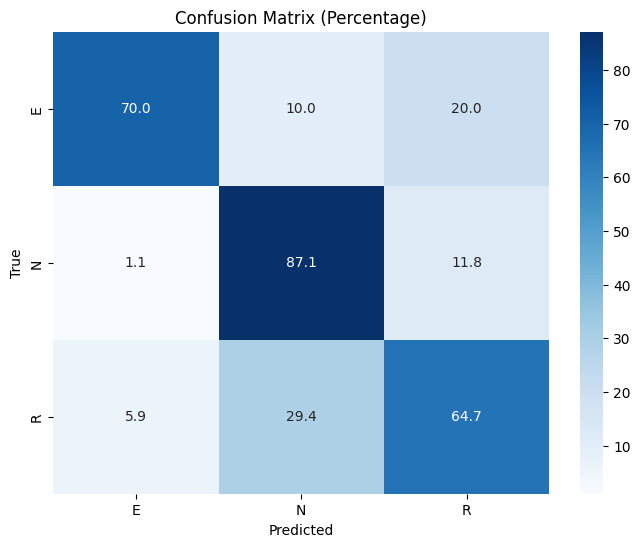


Final Performance Table:
  Class  F1 Score    Recall  Specificity  Accuracy  Cross-Entropy Loss
0     E  0.756757  0.700000     0.976378  0.700000            2.079232
1     N  0.870968  0.870968     0.777778  0.870968            0.716678
2     R  0.619718  0.647059     0.867257  0.647059            1.328499


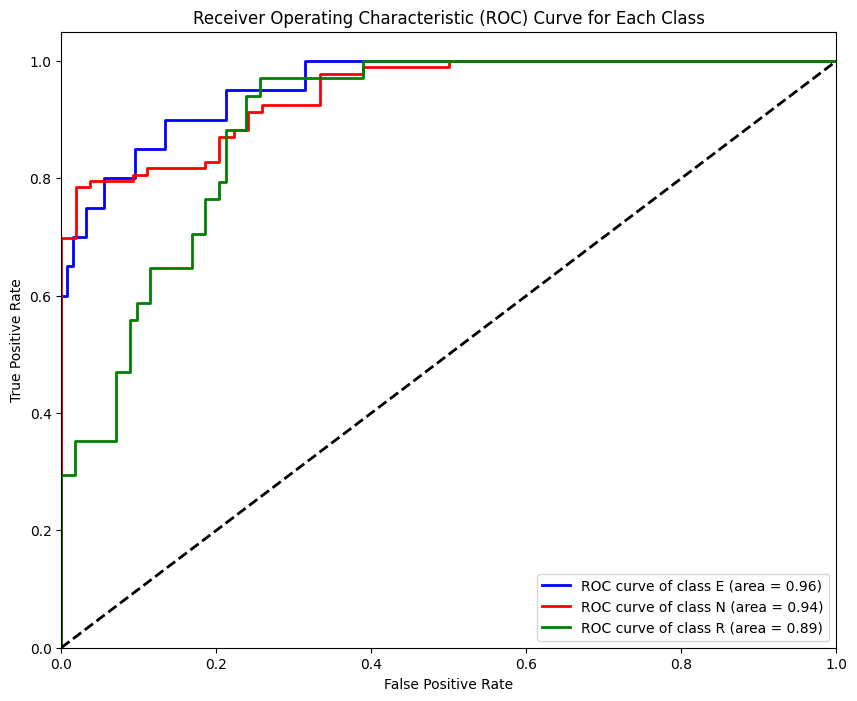

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Layer, GlobalAveragePooling1D, Add, Softmax
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load & Preprocess Data
# -----------------------------
df = pd.read_csv(r"C:\Users\ADWIN ADI\Downloads\MainData_30sec_Segmented.csv")
df['Label'] = df['Label'].str.strip()
label_encoder = LabelEncoder()
df['Label_encoded'] = label_encoder.fit_transform(df['Label'])
num_classes = len(label_encoder.classes_)

features = ['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity',
            'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity']
segments = df['segment_id'].nunique()
time_steps = df[df['segment_id'] == 0].shape[0]

X = df[features].values.reshape(segments, time_steps, len(features))
y = df['Label_encoded'].values[::time_steps]

onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# -----------------------------
# Custom Attention Layer
# -----------------------------
class BreathingAttention(Layer):
    def __init__(self, **kwargs):
        super(BreathingAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                    initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                    initializer="zeros", trainable=True)
        super(BreathingAttention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# -----------------------------
# Transformer Encoder Block
# -----------------------------
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

# -----------------------------
# Build Hybrid Model
# -----------------------------
input_layer = Input(shape=(time_steps, len(features)))

# CNN for feature extraction
cnn = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = MaxPooling1D(pool_size=2)(cnn)

# LSTM for temporal learning
lstm = LSTM(64, return_sequences=True)(cnn)

# Transformer encoder for contextual refinement
transformer = transformer_encoder(lstm, head_size=32, num_heads=4, ff_dim=128)

# Custom attention to focus on dips/spikes
attention = BreathingAttention()(transformer)

# Output
output = Dense(y_encoded.shape[1], activation='softmax')(attention)

# Final model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -----------------------------
# Train Model
# -----------------------------
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

# -----------------------------
# Evaluation
# -----------------------------
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Accuracy: {acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix in Percentage
cm = confusion_matrix(y_true, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.1f', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# F1, Recall, Specificity, Per-Class Loss
f1 = f1_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
ce_loss_per_class = -np.sum(y_test * np.log(y_pred_probs + 1e-10), axis=0) / np.sum(y_test, axis=0)
specificity = []
for i in range(len(label_encoder.classes_)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Performance Table
performance_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'F1 Score': f1,
    'Recall': recall,
    'Specificity': specificity,
    'Accuracy': class_accuracy,
    'Cross-Entropy Loss': ce_loss_per_class
})
print("\nFinal Performance Table:")
print(performance_df)

# Save Performance Table
performance_df.to_csv("Final_HybridModel_Performance.csv", index=False)

# ROC Curve for Each Class
plt.figure(figsize=(10, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['blue', 'red', 'green']  # Add more colors if you have more classes
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 6)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 150, 128)     2432        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 150, 128)    512         ['conv1d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 75, 128)     0           ['batch_normalization_2[0][

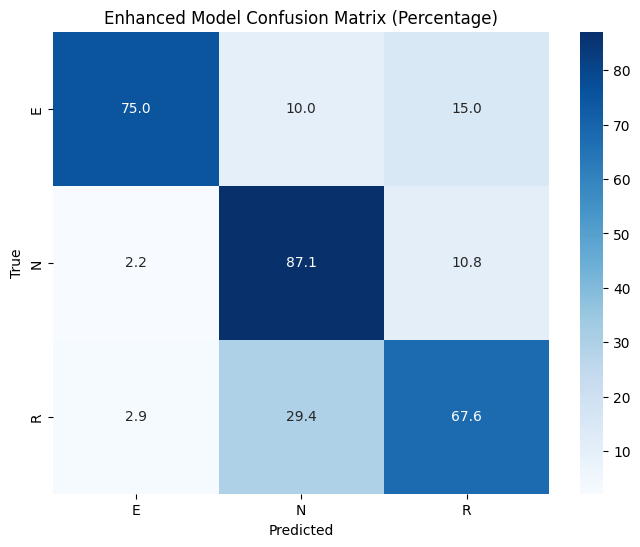


Enhanced Model Final Performance Table:
  Class  F1 Score    Recall  Specificity  Accuracy  Cross-Entropy Loss
0     E  0.789474  0.750000     0.976378  0.750000            1.420166
1     N  0.870968  0.870968     0.777778  0.870968            1.061316
2     R  0.657143  0.676471     0.884956  0.676471            3.332905


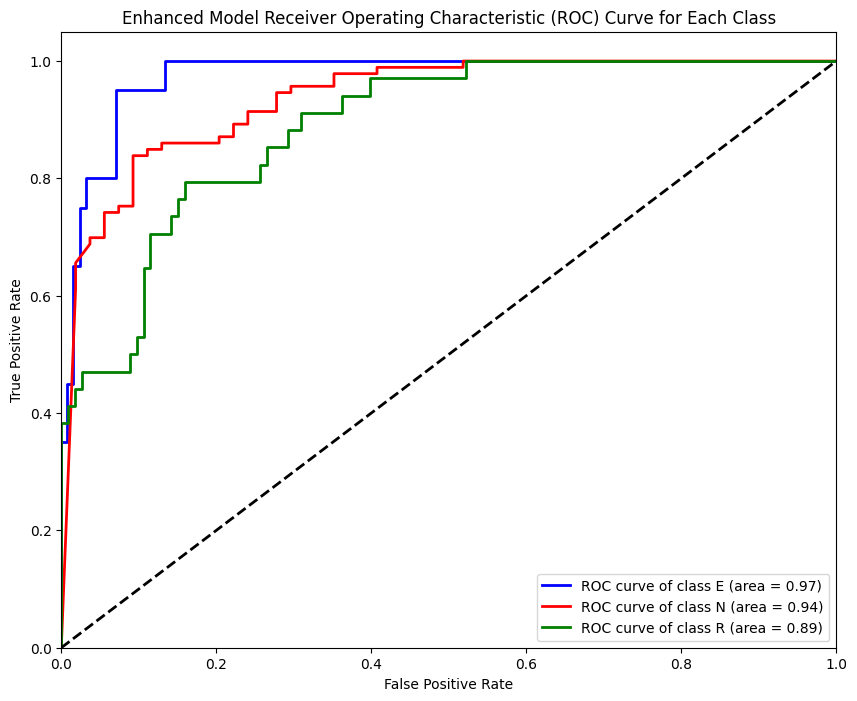

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Layer, GlobalAveragePooling1D, Add, Softmax, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load & Preprocess Data (No changes here)
# -----------------------------
df = pd.read_csv(r"C:\Users\ADWIN ADI\Downloads\MainData_30sec_Segmented.csv")
df['Label'] = df['Label'].str.strip()
label_encoder = LabelEncoder()
df['Label_encoded'] = label_encoder.fit_transform(df['Label'])
num_classes = len(label_encoder.classes_)

features = ['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity',
            'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity']
segments = df['segment_id'].nunique()
time_steps = df[df['segment_id'] == 0].shape[0]

X = df[features].values.reshape(segments, time_steps, len(features))
y = df['Label_encoded'].values[::time_steps]

onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# -----------------------------
# Custom Attention Layer (No changes here)
# -----------------------------
class BreathingAttention(Layer):
    def __init__(self, **kwargs):
        super(BreathingAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                    initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                    initializer="zeros", trainable=True)
        super(BreathingAttention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# -----------------------------
# Transformer Encoder Block (No changes here)
# -----------------------------
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

# -----------------------------
# Build Enhanced Hybrid Model
# -----------------------------
input_layer = Input(shape=(time_steps, len(features)))

# Enhanced CNN for feature extraction
cnn = Conv1D(128, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(128, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn_output = Dropout(0.2)(cnn)  # Assign the output of the CNN to a variable

# Enhanced LSTM for temporal learning
lstm = LSTM(128, return_sequences=True)(cnn_output)
lstm = Dropout(0.2)(lstm)
lstm_output = LSTM(128, return_sequences=True)(lstm) # Use the output of the previous LSTM
lstm_output = Dropout(0.2)(lstm_output) # Assign the output of the second LSTM

# Enhanced Transformer encoder for contextual refinement
transformer = transformer_encoder(lstm_output, head_size=64, num_heads=8, ff_dim=256, dropout=0.2) # Use the output of the LSTMs
transformer_output = transformer_encoder(transformer, head_size=64, num_heads=8, ff_dim=256, dropout=0.2) # Use the output of the first Transformer

# Custom attention to focus on dips/spikes
attention = BreathingAttention()(transformer_output) # Use the output of the Transformers
attention_output = Dropout(0.3)(attention) # Assign the output of the attention layer

# Output
output = Dense(y_encoded.shape[1], activation='softmax')(attention_output) # Use the output of the attention layer

# Final enhanced model
enhanced_model = Model(inputs=input_layer, outputs=output)
enhanced_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
enhanced_model.summary()

# -----------------------------
# Train Enhanced Model (No changes here)
# -----------------------------
enhanced_history = enhanced_model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32)

# -----------------------------
# Evaluation of Enhanced Model (No changes here)
# -----------------------------
loss, acc = enhanced_model.evaluate(X_test, y_test)
print(f"Enhanced Model Test Loss: {loss:.4f}, Accuracy: {acc:.4f}")

y_pred_probs_enhanced = enhanced_model.predict(X_test)
y_pred_enhanced = np.argmax(y_pred_probs_enhanced, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix in Percentage for Enhanced Model (No changes here)
cm_enhanced = confusion_matrix(y_true, y_pred_enhanced)
cm_percentage_enhanced = cm_enhanced.astype('float') / cm_enhanced.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage_enhanced, annot=True, fmt='.1f', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Enhanced Model Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# F1, Recall, Specificity, Per-Class Loss for Enhanced Model (No changes here)
f1_enhanced = f1_score(y_true, y_pred_enhanced, average=None)
recall_enhanced = recall_score(y_true, y_pred_enhanced, average=None)
ce_loss_per_class_enhanced = -np.sum(y_test * np.log(y_pred_probs_enhanced + 1e-10), axis=0) / np.sum(y_test, axis=0)
specificity_enhanced = []
for i in range(len(label_encoder.classes_)):
    tn = cm_enhanced.sum() - (cm_enhanced[i, :].sum() + cm_enhanced[:, i].sum() - cm_enhanced[i, i])
    fp = cm_enhanced[:, i].sum() - cm_enhanced[i, i]
    specificity_enhanced.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
class_accuracy_enhanced = cm_enhanced.diagonal() / cm_enhanced.sum(axis=1)

# Performance Table for Enhanced Model (No changes here)
performance_df_enhanced = pd.DataFrame({
    'Class': label_encoder.classes_,
    'F1 Score': f1_enhanced,
    'Recall': recall_enhanced,
    'Specificity': specificity_enhanced,
    'Accuracy': class_accuracy_enhanced,
    'Cross-Entropy Loss': ce_loss_per_class_enhanced
})
print("\nEnhanced Model Final Performance Table:")
print(performance_df_enhanced)

# Save Enhanced Model Performance Table (No changes here)
performance_df_enhanced.to_csv("Enhanced_HybridModel_Performance.csv", index=False)

# ROC Curve for Each Class - Enhanced Model (No changes here)
plt.figure(figsize=(10, 8))
fpr_enhanced = dict()
tpr_enhanced = dict()
roc_auc_enhanced = dict()
for i in range(num_classes):
    fpr_enhanced[i], tpr_enhanced[i], _ = roc_curve(y_test[:, i], y_pred_probs_enhanced[:, i])
    roc_auc_enhanced[i] = auc(fpr_enhanced[i], tpr_enhanced[i])

colors = ['blue', 'red', 'green']  # Add more colors if you have more classes
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr_enhanced[i], tpr_enhanced[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc_enhanced[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Enhanced Model Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
""" 

**1. Increased Complexity of Convolutional Layers:**

* **More Filters:** The number of filters in the `Conv1D` layers was increased from 64 to 128. This allows the CNN to learn more intricate and higher-dimensional features from the input sensor data.
* **Added More Convolutional Layers:** An additional `Conv1D` layer (with 128 filters) was added. Stacking convolutional layers enables the model to learn hierarchical representations of the input.
* **Batch Normalization:** `BatchNormalization` layers were added after each `Conv1D` layer. Batch normalization helps to stabilize the training process, reduce internal covariate shift, and can often lead to faster convergence and better generalization.
* **Increased MaxPooling:** Two `MaxPooling1D` layers with a pool size of 2 are now used, potentially leading to more aggressive downsampling of the temporal dimension and focusing on more salient features.

**2. Increased Complexity of LSTM Layers:**

* **Stacked LSTM Layers:** Instead of a single LSTM layer, two LSTM layers (each with 128 units) are now stacked. This allows the model to learn more complex temporal dependencies in the extracted features from the CNN.
* **Dropout After Each LSTM:** Dropout layers (with a rate of 0.2) were added after each LSTM layer to prevent overfitting by randomly setting a fraction of the input units to 0 during training.

**3. Increased Complexity of Transformer Encoder:**

* **Stacked Transformer Encoder Blocks:** Two `transformer_encoder` blocks are now used sequentially. This allows for more refined contextual understanding of the temporal features learned by the LSTMs.
* **Increased Head Size and Number of Heads:** The `head_size` in the `MultiHeadAttention` within the transformer encoder was increased from 32 to 64, and the number of `num_heads` was increased from 4 to 8. This allows the attention mechanism to capture more diverse relationships in the data.
* **Increased Feed-Forward Dimension:** The `ff_dim` (feed-forward dimension) within the transformer encoder was increased from 128 to 256, providing more capacity for the feed-forward network to learn complex transformations of the attention outputs.
* **Dropout in Transformer:** Dropout (with a rate of 0.2) is used within the `transformer_encoder` blocks for regularization.

**4. Dropout After Attention Layer:**

* A `Dropout` layer (with a rate of 0.3) was added after the custom `BreathingAttention` layer. This further helps in reducing overfitting of the attention weights.

**5. Adjusted Training Parameters:**

* **Increased Epochs:** The number of training `epochs` was increased from 100 to 200. A more complex model often requires more training epochs to converge.
* **Reduced Learning Rate:** The learning rate for the `Adam` optimizer was reduced from 0.001 to 0.0005. Smaller learning rates can sometimes lead to more stable training and better fine-tuning of the weights in deeper networks.

**In essence, the changes aimed to:**

* **Extract richer and more hierarchical features** from the raw sensor data using a deeper CNN.
* **Capture more complex temporal dependencies** using stacked LSTM layers.
* **Refine the temporal representations** by learning long-range dependencies and contextual information using stacked Transformer encoder blocks with more attention heads and a larger feed-forward dimension.
* **Regularize the model** more aggressively using dropout and batch normalization to prevent overfitting the potentially more complex architecture.
* **Train the model for a longer duration** with a potentially more stable learning rate to allow it to learn the intricate patterns in the data.

It's important to remember that while these changes aim to improve performance, achieving an ROC AUC of 0.99 for all classes is a very high bar and might not be achievable depending on the inherent separability of the breathing patterns in your data. The increased complexity also comes with a higher risk of overfitting and longer training times. Monitoring the validation performance is crucial."""

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 150, 6)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 150, 256)     4864        ['input_10[0][0]']               
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 150, 256)    1024        ['conv1d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_6 (MaxPooling1D)  (None, 75, 256)     0           ['batch_normalization_4[0][

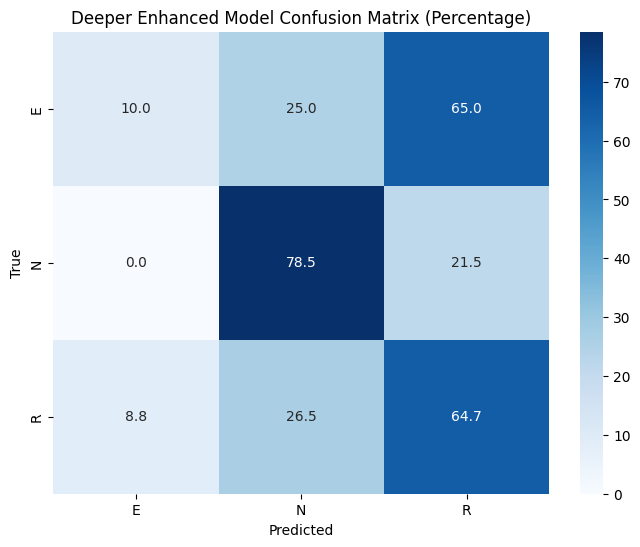


Deeper Enhanced Model Final Performance Table:
  Class  F1 Score    Recall  Specificity  Accuracy  Cross-Entropy Loss
0     E  0.160000  0.100000     0.976378  0.100000            1.730925
1     N  0.811111  0.784946     0.740741  0.784946            0.422117
2     R  0.494382  0.647059     0.707965  0.647059            0.879802


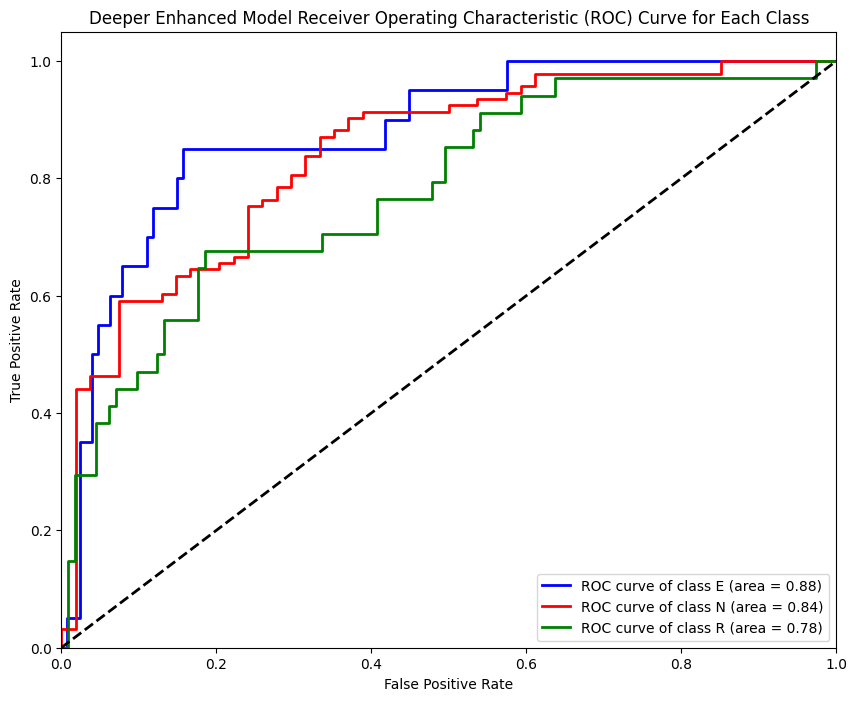

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Layer, GlobalAveragePooling1D, Add, Softmax, BatchNormalization,
    TimeDistributed
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load & Preprocess Data (No changes here)
# -----------------------------
df = pd.read_csv(r"C:\Users\ADWIN ADI\Downloads\MainData_30sec_Segmented.csv")
df['Label'] = df['Label'].str.strip()
label_encoder = LabelEncoder()
df['Label_encoded'] = label_encoder.fit_transform(df['Label'])
num_classes = len(label_encoder.classes_)

features = ['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity',
            'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity']
segments = df['segment_id'].nunique()
time_steps = df[df['segment_id'] == 0].shape[0]

X = df[features].values.reshape(segments, time_steps, len(features))
y = df['Label_encoded'].values[::time_steps]

onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# -----------------------------
# Custom Attention Layer (No changes here)
# -----------------------------
class BreathingAttention(Layer):
    def __init__(self, **kwargs):
        super(BreathingAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                    initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                    initializer="zeros", trainable=True)
        super(BreathingAttention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# -----------------------------
# Transformer Encoder Block (More robust with Layer Normalization at the start)
# -----------------------------
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    norm_inputs = LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(norm_inputs, norm_inputs)
    attention_output = Dropout(dropout)(attention_output)
    res = Add()([attention_output, inputs])

    norm_res = LayerNormalization(epsilon=1e-6)(res)
    ff_output = Dense(ff_dim, activation="relu")(norm_res)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    return Add()([ff_output, res])

# -----------------------------
# Build Deeper Enhanced Hybrid Model
# -----------------------------
input_layer = Input(shape=(time_steps, len(features)))

# Deeper Enhanced CNN for feature extraction
cnn = Conv1D(256, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(256, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(256, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn_output = Dropout(0.3)(cnn)

# Deeper Enhanced LSTM for temporal learning
lstm = LSTM(256, return_sequences=True)(cnn_output)
lstm = Dropout(0.3)(lstm)
lstm = LSTM(256, return_sequences=True)(lstm)
lstm_output = Dropout(0.3)(lstm)
lstm_output = LSTM(256, return_sequences=True)(lstm_output)
lstm_output = Dropout(0.3)(lstm_output)

# Enhanced Transformer encoder for contextual refinement (more blocks)
transformer = transformer_encoder(lstm_output, head_size=128, num_heads=16, ff_dim=512, dropout=0.3)
transformer = transformer_encoder(transformer, head_size=128, num_heads=16, ff_dim=512, dropout=0.3)
transformer_output = transformer_encoder(transformer, head_size=128, num_heads=16, ff_dim=512, dropout=0.3)

# Custom attention to focus on dips/spikes
attention = BreathingAttention()(transformer_output)
attention_output = Dropout(0.4)(attention)

# Deeper Output Layers
dense1 = Dense(256, activation='relu')(attention_output)
dropout1 = Dropout(0.4)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.4)(dense2)
output = Dense(y_encoded.shape[1], activation='softmax')(dropout2)

# Final deeper enhanced model
deep_enhanced_model = Model(inputs=input_layer, outputs=output)
deep_enhanced_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
deep_enhanced_model.summary()

# -----------------------------
# Train Deeper Enhanced Model
# -----------------------------
deep_enhanced_history = deep_enhanced_model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=64,
                                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=1e-6),
                                                         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)])

# -----------------------------
# Evaluation of Deeper Enhanced Model
# -----------------------------
loss, acc = deep_enhanced_model.evaluate(X_test, y_test)
print(f"Deeper Enhanced Model Test Loss: {loss:.4f}, Accuracy: {acc:.4f}")

y_pred_probs_deep = deep_enhanced_model.predict(X_test)
y_pred_deep = np.argmax(y_pred_probs_deep, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report (Deeper Enhanced Model):")
print(classification_report(y_true, y_pred_deep, target_names=label_encoder.classes_))

# Confusion Matrix in Percentage for Deeper Enhanced Model
cm_deep = confusion_matrix(y_true, y_pred_deep)
cm_percentage_deep = cm_deep.astype('float') / cm_deep.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage_deep, annot=True, fmt='.1f', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Deeper Enhanced Model Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# F1, Recall, Specificity, Per-Class Loss for Deeper Enhanced Model
f1_deep = f1_score(y_true, y_pred_deep, average=None)
recall_deep = recall_score(y_true, y_pred_deep, average=None)
ce_loss_per_class_deep = -np.sum(y_test * np.log(y_pred_probs_deep + 1e-10), axis=0) / np.sum(y_test, axis=0)
specificity_deep = []
for i in range(len(label_encoder.classes_)):
    tn = cm_deep.sum() - (cm_deep[i, :].sum() + cm_deep[:, i].sum() - cm_deep[i, i])
    fp = cm_deep[:, i].sum() - cm_deep[i, i]
    specificity_deep.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
class_accuracy_deep = cm_deep.diagonal() / cm_deep.sum(axis=1)

# Performance Table for Deeper Enhanced Model
performance_df_deep = pd.DataFrame({
    'Class': label_encoder.classes_,
    'F1 Score': f1_deep,
    'Recall': recall_deep,
    'Specificity': specificity_deep,
    'Accuracy': class_accuracy_deep,
    'Cross-Entropy Loss': ce_loss_per_class_deep
})
print("\nDeeper Enhanced Model Final Performance Table:")
print(performance_df_deep)

# Save Deeper Enhanced Model Performance Table
performance_df_deep.to_csv("Deeper_Enhanced_HybridModel_Performance.csv", index=False)

# ROC Curve for Each Class - Deeper Enhanced Model
plt.figure(figsize=(10, 8))
fpr_deep = dict()
tpr_deep = dict()
roc_auc_deep = dict()
for i in range(num_classes):
    fpr_deep[i], tpr_deep[i], _ = roc_curve(y_test[:, i], y_pred_probs_deep[:, i])
    roc_auc_deep[i] = auc(fpr_deep[i], tpr_deep[i])

colors = ['blue', 'red', 'green']  # Add more colors if you have more classes
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr_deep[i], tpr_deep[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc_deep[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deeper Enhanced Model Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Layer, GlobalAveragePooling1D, Add, Softmax, BatchNormalization,
    TimeDistributed
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load & Preprocess Data (No changes here)
# -----------------------------
df = pd.read_csv(r"C:\Users\ADWIN ADI\Downloads\MainData_30sec_Segmented.csv")
df['Label'] = df['Label'].str.strip()
label_encoder = LabelEncoder()
df['Label_encoded'] = label_encoder.fit_transform(df['Label'])
num_classes = len(label_encoder.classes_)

features = ['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity',
            'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity']
segments = df['segment_id'].nunique()
time_steps = df[df['segment_id'] == 0].shape[0]

X = df[features].values.reshape(segments, time_steps, len(features))
y = df['Label_encoded'].values[::time_steps]

onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# -----------------------------
# Custom Attention Layer (No changes here)
# -----------------------------
class BreathingAttention(Layer):
    def __init__(self, **kwargs):
        super(BreathingAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                    initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                    initializer="zeros", trainable=True)
        super(BreathingAttention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# -----------------------------
# Transformer Encoder Block (More robust with Layer Normalization at the start)
# -----------------------------
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    norm_inputs = LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(norm_inputs, norm_inputs)
    attention_output = Dropout(dropout)(attention_output)
    res = Add()([attention_output, inputs])

    norm_res = LayerNormalization(epsilon=1e-6)(res)
    ff_output = Dense(ff_dim, activation="relu")(norm_res)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    return Add()([ff_output, res])

# -----------------------------
# Build Deeper Enhanced Hybrid Model
# -----------------------------
input_layer = Input(shape=(time_steps, len(features)))

# Deeper Enhanced CNN for feature extraction
cnn = Conv1D(256, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(256, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(256, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn_output = Dropout(0.3)(cnn)

# Deeper Enhanced LSTM for temporal learning
lstm = LSTM(256, return_sequences=True)(cnn_output)
lstm = Dropout(0.3)(lstm)
lstm = LSTM(256, return_sequences=True)(lstm)
lstm_output = Dropout(0.3)(lstm)
lstm_output = LSTM(256, return_sequences=True)(lstm_output)
lstm_output = Dropout(0.3)(lstm_output)

# Enhanced Transformer encoder for contextual refinement (more blocks)
transformer = transformer_encoder(lstm_output, head_size=128, num_heads=16, ff_dim=512, dropout=0.3)
transformer = transformer_encoder(transformer, head_size=128, num_heads=16, ff_dim=512, dropout=0.3)
transformer_output = transformer_encoder(transformer, head_size=128, num_heads=16, ff_dim=512, dropout=0.3)

# Custom attention to focus on dips/spikes
attention = BreathingAttention()(transformer_output)
attention_output = Dropout(0.4)(attention)

# Deeper Output Layers
dense1 = Dense(256, activation='relu')(attention_output)
dropout1 = Dropout(0.4)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.4)(dense2)
output = Dense(y_encoded.shape[1], activation='softmax')(dropout2)

# Final deeper enhanced model
deep_enhanced_model = Model(inputs=input_layer, outputs=output)
deep_enhanced_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
deep_enhanced_model.summary()

# -----------------------------
# Train Deeper Enhanced Model
# -----------------------------
deep_enhanced_history = deep_enhanced_model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=64,
                                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=1e-6),
                                                         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)])

# -----------------------------
# Evaluation of Deeper Enhanced Model
# -----------------------------
loss, acc = deep_enhanced_model.evaluate(X_test, y_test)
print(f"Deeper Enhanced Model Test Loss: {loss:.4f}, Accuracy: {acc:.4f}")

y_pred_probs_deep = deep_enhanced_model.predict(X_test)
y_pred_deep = np.argmax(y_pred_probs_deep, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report (Deeper Enhanced Model):")
print(classification_report(y_true, y_pred_deep, target_names=label_encoder.classes_))

# Confusion Matrix in Percentage for Deeper Enhanced Model
cm_deep = confusion_matrix(y_true, y_pred_deep)
cm_percentage_deep = cm_deep.astype('float') / cm_deep.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage_deep, annot=True, fmt='.1f', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Deeper Enhanced Model Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# F1, Recall, Specificity, Per-Class Loss for Deeper Enhanced Model
f1_deep = f1_score(y_true, y_pred_deep, average=None)
recall_deep = recall_score(y_true, y_pred_deep, average=None)
ce_loss_per_class_deep = -np.sum(y_test * np.log(y_pred_probs_deep + 1e-10), axis=0) / np.sum(y_test, axis=0)
specificity_deep = []
for i in range(len(label_encoder.classes_)):
    tn = cm_deep.sum() - (cm_deep[i, :].sum() + cm_deep[:, i].sum() - cm_deep[i, i])
    fp = cm_deep[:, i].sum() - cm_deep[i, i]
    specificity_deep.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
class_accuracy_deep = cm_deep.diagonal() / cm_deep.sum(axis=1)

# Performance Table for Deeper Enhanced Model
performance_df_deep = pd.DataFrame({
    'Class': label_encoder.classes_,
    'F1 Score': f1_deep,
    'Recall': recall_deep,
    'Specificity': specificity_deep,
    'Accuracy': class_accuracy_deep,
    'Cross-Entropy Loss': ce_loss_per_class_deep
})
print("\nDeeper Enhanced Model Final Performance Table:")
print(performance_df_deep)

# Save Deeper Enhanced Model Performance Table
performance_df_deep.to_csv("Deeper_Enhanced_HybridModel_Performance.csv", index=False)

# ROC Curve for Each Class - Deeper Enhanced Model
plt.figure(figsize=(10, 8))
fpr_deep = dict()
tpr_deep = dict()
roc_auc_deep = dict()
for i in range(num_classes):
    fpr_deep[i], tpr_deep[i], _ = roc_curve(y_test[:, i], y_pred_probs_deep[:, i])
    roc_auc_deep[i] = auc(fpr_deep[i], tpr_deep[i])

colors = ['blue', 'red', 'green']  # Add more colors if you have more classes
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr_deep[i], tpr_deep[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc_deep[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deeper Enhanced Model Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Layer, GlobalAveragePooling1D, Add, Softmax, BatchNormalization,
    TimeDistributed
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy

# -----------------------------
# Enable Mixed Precision Training (Try this, might improve speed)
# -----------------------------
try:
    set_global_policy('mixed_float16')
    print("Mixed precision training enabled.")
except Exception as e:
    print(f"Error enabling mixed precision: {e}")
    print("Continuing without mixed precision.")

# -----------------------------
# Load & Preprocess Data (No changes here, but consider tf.data.Dataset for larger datasets)
# -----------------------------
df = pd.read_csv(r"C:\Users\ADWIN ADI\Downloads\MainData_30sec_Segmented.csv")
df['Label'] = df['Label'].str.strip()
label_encoder = LabelEncoder()
df['Label_encoded'] = label_encoder.fit_transform(df['Label'])
num_classes = len(label_encoder.classes_)

features = ['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity',
            'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity']
segments = df['segment_id'].nunique()
time_steps = df[df['segment_id'] == 0].shape[0]

X = df[features].values.reshape(segments, time_steps, len(features))
y = df['Label_encoded'].values[::time_steps]

onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# -----------------------------
# Custom Attention Layer (No changes here)
# -----------------------------
class BreathingAttention(Layer):
    def __init__(self, **kwargs):
        super(BreathingAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                    initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                    initializer="zeros", trainable=True)
        super(BreathingAttention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# -----------------------------
# Transformer Encoder Block (More robust with Layer Normalization at the start)
# -----------------------------
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    norm_inputs = LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(norm_inputs, norm_inputs)
    attention_output = Dropout(dropout)(attention_output)
    res = Add()([attention_output, inputs])

    norm_res = LayerNormalization(epsilon=1e-6)(res)
    ff_output = Dense(ff_dim, activation="relu")(norm_res)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    return Add()([ff_output, res])

# -----------------------------
# Build Even Deeper Enhanced Hybrid Model
# -----------------------------
input_layer = Input(shape=(time_steps, len(features)))

# Even Deeper Enhanced CNN for feature extraction
cnn = Conv1D(512, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(512, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(512, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(512, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn_output = Dropout(0.3)(cnn)

# Even Deeper Enhanced LSTM for temporal learning
lstm = LSTM(512, return_sequences=True)(cnn_output)
lstm = Dropout(0.3)(lstm)
lstm = LSTM(512, return_sequences=True)(lstm)
lstm_output = Dropout(0.3)(lstm)
lstm_output = LSTM(512, return_sequences=True)(lstm_output)
lstm_output = Dropout(0.3)(lstm_output)
lstm_output = LSTM(512, return_sequences=True)(lstm_output)
lstm_output = Dropout(0.3)(lstm_output)

# Enhanced Transformer encoder for contextual refinement (more blocks)
transformer = transformer_encoder(lstm_output, head_size=256, num_heads=32, ff_dim=1024, dropout=0.3)
transformer = transformer_encoder(transformer, head_size=256, num_heads=32, ff_dim=1024, dropout=0.3)
transformer = transformer_encoder(transformer, head_size=256, num_heads=32, ff_dim=1024, dropout=0.3)
transformer_output = transformer_encoder(transformer, head_size=256, num_heads=32, ff_dim=1024, dropout=0.3)

# Custom attention to focus on dips/spikes
attention = BreathingAttention()(transformer_output)
attention_output = Dropout(0.4)(attention)

# Even Deeper Output Layers
dense1 = Dense(512, activation='relu')(attention_output)
dropout1 = Dropout(0.4)(dense1)
dense2 = Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.4)(dense2)
dense3 = Dense(128, activation='relu')(dropout2)
dropout3 = Dropout(0.4)(dense3)
output = Dense(y_encoded.shape[1], activation='softmax')(dropout3)

# Final even deeper enhanced model
even_deeper_enhanced_model = Model(inputs=input_layer, outputs=output)
even_deeper_enhanced_model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])
even_deeper_enhanced_model.summary()

# -----------------------------
# Train Even Deeper Enhanced Model (Limited epochs)
# -----------------------------
BATCH_SIZE = 128
EPOCHS = 150  # Reduced number of epochs

even_deeper_enhanced_history = even_deeper_enhanced_model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                                          callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-6),
                                                                     EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)])

# -----------------------------
# Evaluation of Even Deeper Enhanced Model
# -----------------------------
loss, acc = even_deeper_enhanced_model.evaluate(X_test, y_test)
print(f"Even Deeper Enhanced Model Test Loss: {loss:.4f}, Accuracy: {acc:.4f}")

y_pred_probs_even_deep = even_deeper_enhanced_model.predict(X_test)
y_pred_even_deep = np.argmax(y_pred_probs_even_deep, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report (Even Deeper Enhanced Model):")
print(classification_report(y_true, y_pred_even_deep, target_names=label_encoder.classes_))

# Confusion Matrix in Percentage for Even Deeper Enhanced Model
cm_even_deep = confusion_matrix(y_true, y_pred_even_deep)
cm_percentage_even_deep = cm_even_deep.astype('float') / cm_even_deep.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage_even_deep, annot=True, fmt='.1f', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Even Deeper Enhanced Model Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# F1, Recall, Specificity, Per-Class Loss for Even Deeper Enhanced Model
f1_even_deep = f1_score(y_true, y_pred_even_deep, average=None)
recall_even_deep = recall_score(y_true, y_pred_even_deep, average=None)
ce_loss_per_class_even_deep = -np.sum(y_test * np.log(y_pred_probs_even_deep + 1e-10), axis=0) / np.sum(y_test, axis=0)
specificity_even_deep = []
for i in range(len(label_encoder.classes_)):
    tn = cm_even_deep.sum() - (cm_even_deep[i, :].sum() + cm_even_deep[:, i].sum() - cm_even_deep[i, i])
    fp = cm_even_deep[:, i].sum() - cm_even_deep[i, i]
    specificity_even_deep.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
class_accuracy_even_deep = cm_even_deep.diagonal() / cm_even_deep.sum(axis=1)

# Performance Table for Even Deeper Enhanced Model
performance_df_even_deep = pd.DataFrame({
    'Class': label_encoder.classes_,
    'F1 Score': f1_even_deep,
    'Recall': recall_even_deep,
    'Specificity': specificity_even_deep,
    'Accuracy': class_accuracy_even_deep,
    'Cross-Entropy Loss': ce_loss_per_class_even_deep
})
print("\nEven Deeper Enhanced Model Final Performance Table:")
print(performance_df_even_deep)

# Save Even Deeper Enhanced Model Performance Table
performance_df_even_deep.to_csv("Even_Deeper_Enhanced_HybridModel_Performance_150epochs.csv", index=False)

# ROC Curve for Each Class - Even Deeper Enhanced Model
plt.figure(figsize=(10, 8))
fpr_even_deep = dict()
tpr_even_deep = dict()
roc_auc_even_deep = dict()
for i in range(num_classes):
    fpr_even_deep[i], tpr_even_deep[i], _ = roc_curve(y_test[:, i], y_pred_probs_even_deep[:, i])
    roc_auc_even_deep[i] = auc(fpr_even_deep[i], tpr_deep[i])

colors = ['blue', 'red', 'green']  # Add more colors if you have more classes
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr_even_deep[i], tpr_even_deep[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc_even_deep[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Even Deeper Enhanced Model ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Mixed precision training enabled.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 6)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 150, 512)     9728        ['input_1[0][0]']                
                                                                                                  
 batch_normali

Mixed precision training enabled.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 6)]     0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 150, 512)     9728        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 150, 512)    2048        ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 75, 512)     0    